# Wheat Disease Detection

In [34]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_dir = '/kaggle/input/behzad-safari-jalal/data/train'
brown_rust_dir = os.path.join(train_dir, 'Brown_rust')
healthy_dir = os.path.join(train_dir, 'Healthy')
yellow_rust_dir = os.path.join(train_dir, 'Yellow_rust')
septoria_dir = '/kaggle/input/wheat-leaf-dataset/wheat_leaf/septoria'

In [5]:
# Function to read images from a directory
def read_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
# Function to resize images
def resize_images(images, target_size=(299, 299)):  # InceptionV3 input size
    resized_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (assuming BGR input)
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

In [7]:
# Read images from each class directory
brown_rust_images = read_images_from_dir(brown_rust_dir)
healthy_images = read_images_from_dir(healthy_dir)
yellow_rust_images = read_images_from_dir(yellow_rust_dir)
septoria_images = read_images_from_dir(septoria_dir)

In [8]:
# Print the number of images in each class
print("Number of Brown Rust images:", len(brown_rust_images))
print("Number of Healthy images:", len(healthy_images))
print("Number of Yellow Rust images:", len(yellow_rust_images))
print("Number of Septoria images:", len(septoria_images))


Number of Brown Rust images: 902
Number of Healthy images: 1116
Number of Yellow Rust images: 924
Number of Septoria images: 97


In [9]:
# Number of images in each class
classes = ['Brown Rust', 'Healthy', 'Yellow Rust', 'Septoria']
counts = [len(brown_rust_images), len(healthy_images), len(yellow_rust_images), len(septoria_images)]

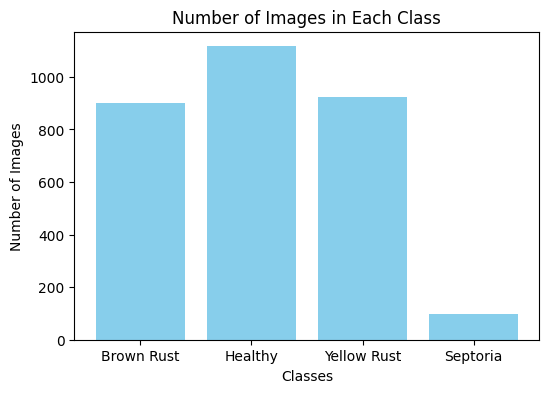

In [10]:
# Create bar graph
plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [11]:
# Resize images for each class
target_size = (299, 299)  # InceptionV3 input size
resized_brown_rust = resize_images(brown_rust_images, target_size)
resized_healthy = resize_images(healthy_images, target_size)
resized_yellow_rust = resize_images(yellow_rust_images, target_size)
resized_septoria = resize_images(septoria_images, target_size)

In [12]:
# Normalize images for each class
def normalize_images(images):
    return images.astype('float32') / 255.0

# Normalize images
normalized_brown_rust = normalize_images(resized_brown_rust)
normalized_healthy = normalize_images(resized_healthy)
normalized_yellow_rust = normalize_images(resized_yellow_rust)
normalized_septoria = normalize_images(resized_septoria)

In [13]:
# Delete unnecessary variables to free up memory
del brown_rust_images, healthy_images, yellow_rust_images, septoria_images
del resized_brown_rust, resized_healthy, resized_yellow_rust, resized_septoria

In [14]:
# Concatenate images and labels
X = np.concatenate((normalized_brown_rust, normalized_healthy, normalized_yellow_rust, normalized_septoria), axis=0)
y = np.array([0]*len(normalized_brown_rust) + [1]*len(normalized_healthy) + [2]*len(normalized_yellow_rust) + [3]*len(normalized_septoria))


In [15]:
# Shuffle X and y in unison
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [18]:
# Load InceptionV3 model pre-trained on ImageNet without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes now


In [20]:
# Combine the base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Suppress the specific warning
warnings.filterwarnings("ignore", message="Fallback to op-by-op mode because memset node breaks graph update")

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
 1/69 ━━━━━━━━━━━━━━━━━━━━ 35:49 32s/step - accuracy: 0.2812 - loss: 1.4551

I0000 00:00:1709492561.123375     154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709492561.175563     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5923 - loss: 0.9577

W0000 00:00:1709492583.568215     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709492590.095814     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 663ms/step - accuracy: 0.5943 - loss: 0.9541 - val_accuracy: 0.8975 - val_loss: 0.3812
Epoch 2/20


W0000 00:00:1709492606.276301     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.8929 - loss: 0.3518 - val_accuracy: 0.9508 - val_loss: 0.2338
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9453 - loss: 0.2123 - val_accuracy: 0.9549 - val_loss: 0.1745
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9478 - loss: 0.1714 - val_accuracy: 0.9508 - val_loss: 0.1526
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9592 - loss: 0.1351 - val_accuracy: 0.9631 - val_loss: 0.1254
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9735 - loss: 0.1074 - val_accuracy: 0.9631 - val_loss: 0.1190
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9731 - loss: 0.0946 - val_accuracy: 0.9672 - val_loss: 0.1079
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9814 - loss: 0.0759 - val_accuracy: 0.9713 - val_loss: 0.1000
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9810 - loss: 0.0761 - val_accuracy: 0.9713 - val_

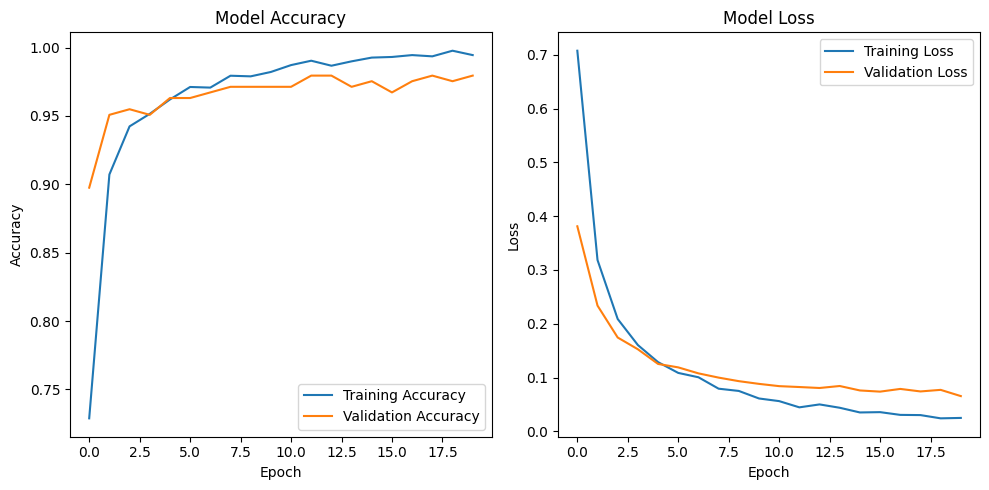

In [23]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluate the model on test data
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.9835526347160339


In [25]:
# Predict labels
y_pred = np.argmax(model.predict(X_test), axis=-1)
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=-1)

 2/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step

W0000 00:00:1709492858.760250     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step


In [26]:
# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.9837745789105117
Recall: 0.9835526315789473
F1-score: 0.9836103468407634


In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[163   1   2   0]
 [  3 223   0   0]
 [  4   0 190   0]
 [  0   0   0  22]]


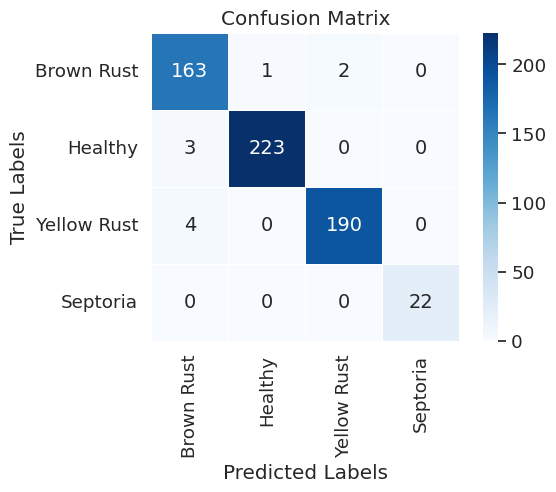

In [36]:
# Confusion Matrix
cm = [[163, 1, 2, 0],
      [3, 223, 0, 0],
      [4, 0, 190, 0],
      [0, 0, 0, 22]]

# Labels for the classes
classes = ['Brown Rust', 'Healthy', 'Yellow Rust', 'Septoria']

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=classes, yticklabels=classes, linewidths=.5, annot_kws={"size": 14})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Define a function to predict the label of an uploaded image
def predict_uploaded_image(model, image_file):
    # Load and preprocess the image
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (299, 299))  # Resize to match model's expected sizing
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img)
    
    # Get the predicted class
    class_idx = np.argmax(predictions)
    
    # Define the class labels
    class_names = {
        0: 'Brown Rust',
        1: 'Healthy',
        2: 'Yellow Rust',
        3: 'Septoria'
    }
    
    # Get the predicted class label
    predicted_class = class_names[class_idx]
    
    # Get the confidence score
    confidence = predictions[0][class_idx]

    return predicted_class, confidence

# Path to the image you want to predict
image_path = '/kaggle/input/wheat-leaf-dataset/wheat_leaf/septoria/los(1).JPG'

# Predict the image
predicted_class, confidence = predict_uploaded_image(model, image_path)

# Print the result
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: Septoria
Confidence: 0.98783803


In [37]:
# Save the model
model.save('Wheat-Model.h5')  # Saves the model to a HDF5 file